In [10]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision 
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.2.0+cpu
torchvision version: 0.17.0+cpu


In [11]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="data", # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well
)

# Setup testing data
test_data = datasets.FashionMNIST(
    root="data",
    train=False, # get test data
    download=True,
    transform=ToTensor()
)

In [12]:
image, label = train_data[0]
label

9

In [13]:
image.shape

torch.Size([1, 28, 28])

In [14]:
# How many samples are there? 
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(60000, 60000, 10000, 10000)

In [15]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

Text(0.5, 1.0, '9')

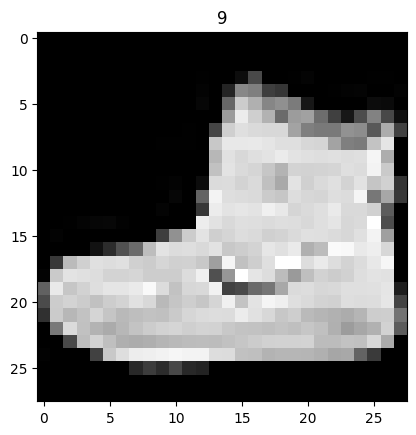

In [16]:
plt.imshow(image.squeeze(), cmap='gray')
plt.title(label)

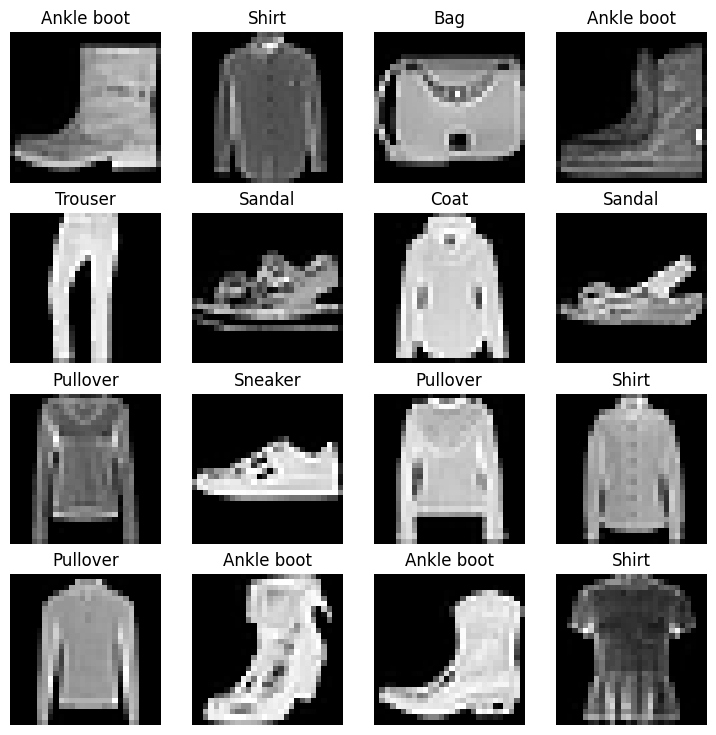

In [17]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);

In [18]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(train_data,
                               batch_size=BATCH_SIZE,
                               shuffle=True)

test_dataloader = DataLoader(test_data,
                               batch_size=BATCH_SIZE,
                               shuffle=False)

print(f"Dataloaders: {train_dataloader, test_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x000002550C142B00>, <torch.utils.data.dataloader.DataLoader object at 0x000002550BE10820>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


In [19]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Text(0.5, 1.0, 'Shirt')

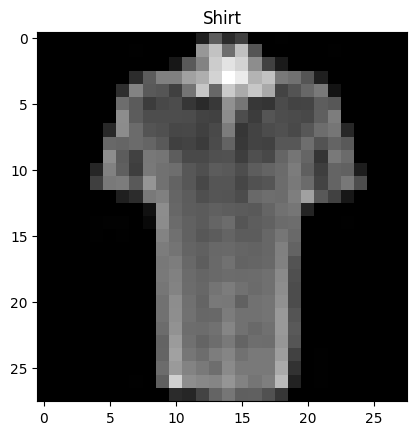

In [20]:
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])

In [21]:
flatten_model = nn.Flatten()

x = train_features_batch[0]
flattend_x = flatten_model(x)
#[color_channels, height, width] -> [color_channels, height*width]
print(x.shape, flattend_x.shape)

torch.Size([1, 28, 28]) torch.Size([1, 784])


In [22]:
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_features, hidden_units, output_features, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_features),
        )

    def forward(self, x):
        return self.layer_stack(x)
    


In [23]:
torch.manual_seed(42)

model_0 = FashionMNISTModelV0(
    input_features=784,
    hidden_units=10,
    output_features=len(class_names)
)

In [24]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr = 0.01)


In [25]:
from tqdm.auto import tqdm

epochs = 3

for epoch in tqdm(range(epochs)):
    print('epoch:', epoch)
    train_loss = 0

    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train()
        y_pred = model_0(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")
    
    train_loss /= len(train_dataloader)
    model_0.eval()
    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for X, y in test_dataloader:
            test_pred = model_0(X)
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 0
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.56466 | Test loss: 0.51697, Test acc: 82.42%

epoch: 1
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.50075 | Test loss: 0.51439, Test acc: 82.43%

epoch: 2
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.48838 | Test loss: 0.52218, Test acc: 82.52%



In [26]:


torch.manual_seed(42)
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn):

    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Make predictions with the model
            y_pred = model(X)
            
            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, 
                                y_pred=y_pred.argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)
        
        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)
        
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

# Calculate model 0 results on test dataset
model_0_results = eval_model(model=model_0, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn
)
model_0_results


{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.5221832394599915,
 'model_acc': 82.5179712460064}

In [27]:
class FashionMNISTModelV1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # flatten inputs into single vector
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )
    
    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)
    


In [28]:
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape=784, # number of input features
    hidden_units=10,
    output_shape=len(class_names) # number of output classes desired
) # send model to GPU if it's available


In [29]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), 
                            lr=0.1)

In [30]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn):
    train_loss, train_acc = 0, 0
    model.train()
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")


In [31]:
def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              ):
    test_loss, test_acc = 0, 0
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [32]:
epochs = 10


for epoch in tqdm(range(epochs)):
    print('epoch', epoch)
    train_step(model=model_1,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn)
    test_step(model=model_1,
              data_loader=test_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn)

  0%|          | 0/10 [00:00<?, ?it/s]

epoch 0
Train loss: 1.05878 | Train accuracy: 62.19%
Test loss: 0.99506 | Test accuracy: 64.13%

epoch 1
Train loss: 0.91331 | Train accuracy: 66.40%
Test loss: 0.90508 | Test accuracy: 66.86%

epoch 2
Train loss: 0.87981 | Train accuracy: 67.25%
Test loss: 0.89485 | Test accuracy: 66.47%

epoch 3
Train loss: 0.86324 | Train accuracy: 67.61%
Test loss: 0.90665 | Test accuracy: 66.48%

epoch 4
Train loss: 0.84879 | Train accuracy: 68.14%
Test loss: 0.86984 | Test accuracy: 67.26%

epoch 5
Train loss: 0.83932 | Train accuracy: 68.32%
Test loss: 0.88762 | Test accuracy: 66.96%

epoch 6
Train loss: 0.83143 | Train accuracy: 68.63%
Test loss: 0.88518 | Test accuracy: 66.57%

epoch 7
Train loss: 0.77189 | Train accuracy: 71.03%
Test loss: 0.68013 | Test accuracy: 75.12%

epoch 8
Train loss: 0.63308 | Train accuracy: 76.68%
Test loss: 0.67117 | Test accuracy: 75.61%

epoch 9
Train loss: 0.62465 | Train accuracy: 76.77%
Test loss: 0.69286 | Test accuracy: 74.95%



In [33]:
model_1_results = eval_model(model=model_1,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)
model_1_results

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6928621530532837,
 'model_acc': 74.95007987220447}

In [34]:
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.5221832394599915,
 'model_acc': 82.5179712460064}

In [35]:
class FashionMNISTModelV2(nn.Module):

    def __init__(self, input_shape, output_shape, hidden_units, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*4*4,
                      out_features=output_shape)
        )

    def forward(self, X):
        X = self.block_1(X)
        print(X.shape)
        X = self.block_2(X)
        print(X.shape)
        X = self.classifier(X)
        print(X.shape)
        return X

In [36]:
model_2 = FashionMNISTModelV2(
    input_shape=1,
    hidden_units=10,
    output_shape=len(class_names)
)
model_2

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=160, out_features=10, bias=True)
  )
)

In [37]:
next(iter(train_dataloader))[0][0].shape

torch.Size([1, 28, 28])

In [38]:
model_2(next(iter(train_dataloader))[0][0]).shape

torch.Size([10, 12, 12])
torch.Size([10, 4, 4])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x16 and 160x10)

In [ ]:
torch.manual_seed(42)

# Create sample batch of random numbers with same size as image batch
images = torch.randn(size=(32, 3, 64, 64)) # [batch_size, color_channels, height, width]
test_image = images[0] # get a single image for testing
print(f"Image batch shape: {images.shape} -> [batch_size, color_channels, height, width]")
print(f"Single image shape: {test_image.shape} -> [color_channels, height, width]") 
print(f"Single image pixel values:\n{test_image}")

Image batch shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Single image shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Single image pixel values:
tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,

In [ ]:
torch.manual_seed(42)

conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size=3,
                       stride=1,
                       padding=0)

conv_layer(test_image).shape

torch.Size([10, 62, 62])

In [ ]:
test_image.unsqueeze(dim=0).shape

torch.Size([1, 3, 64, 64])

In [ ]:
conv_layer(test_image.unsqueeze(dim=0)).shape

torch.Size([1, 10, 62, 62])

In [ ]:
torch.manual_seed(42)

conv_layer_2 = nn.Conv2d(in_channels=3,
                         out_channels=10,
                         kernel_size=(5, 5),
                         stride=2,
                         padding=0)

conv_layer_2(test_image).shape

torch.Size([10, 30, 30])

In [ ]:
conv_layer_2(test_image.unsqueeze(dim=0)).shape

torch.Size([1, 10, 30, 30])

In [ ]:
# Get shapes of weight and bias tensors within conv_layer_2
print(f"conv_layer_2 weight shape: \n{conv_layer_2.weight.shape} -> [out_channels=10, in_channels=3, kernel_size=5, kernel_size=5]")
print(f"\nconv_layer_2 bias shape: \n{conv_layer_2.bias.shape} -> [out_channels=10]")

conv_layer_2 weight shape: 
torch.Size([10, 3, 5, 5]) -> [out_channels=10, in_channels=3, kernel_size=5, kernel_size=5]

conv_layer_2 bias shape: 
torch.Size([10]) -> [out_channels=10]


In [ ]:
max_pool_layer = nn.MaxPool2d(kernel_size=2)
print(test_image.shape)
test_image_through_conv = conv_layer(test_image)
print(test_image_through_conv.shape)
test_image_through_conv_and_max_pool = max_pool_layer(test_image_through_conv)
print(test_image_through_conv_and_max_pool.shape)

torch.Size([3, 64, 64])
torch.Size([10, 62, 62])
torch.Size([10, 31, 31])


In [ ]:
torch.manual_seed(42)

random_tensor = torch.randn(size=(1, 1, 4, 4))
print(f"Random tensor:\n{random_tensor}")
print(f"Random tensor shape: {random_tensor.shape}")

max_pool_layer = nn.MaxPool2d(kernel_size=2)
max_pool_tensor = max_pool_layer(random_tensor)
print(f"\nMax pool tensor:\n{max_pool_tensor} <- this is the maximum value from random_tensor")
print(f"Max pool tensor shape: {max_pool_tensor.shape}")

Random tensor:
tensor([[[[ 1.9269,  1.4873,  0.9007, -2.1055],
          [ 0.6784, -1.2345, -0.0431, -1.6047],
          [-0.7521,  1.6487, -0.3925, -1.4036],
          [-0.7279, -0.5594, -0.7688,  0.7624]]]])
Random tensor shape: torch.Size([1, 1, 4, 4])

Max pool tensor:
tensor([[[[1.9269, 0.9007],
          [1.6487, 0.7624]]]]) <- this is the maximum value from random_tensor
Max pool tensor shape: torch.Size([1, 1, 2, 2])


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.1)

In [ ]:
epochs = 3

for epoch in tqdm(range(epochs)):
    print(epoch)
    train_step(data_loader=train_dataloader,
               model=model_2,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn)
    
    test_step(data_loader=test_dataloader,
              model=model_2,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn)

  0%|          | 0/3 [00:00<?, ?it/s]

0
Train loss: 0.76753 | Train accuracy: 71.25%
Test loss: 0.49687 | Test accuracy: 82.24%

1
Train loss: 0.43030 | Train accuracy: 84.33%
Test loss: 0.40804 | Test accuracy: 85.92%

2
Train loss: 0.37935 | Train accuracy: 86.23%
Test loss: 0.35796 | Test accuracy: 87.22%



In [ ]:
model_2_results = eval_model(model=model_2,
           data_loader=test_dataloader,
           loss_fn=loss_fn,
           accuracy_fn=accuracy_fn)
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3579557538032532,
 'model_acc': 87.22044728434504}

In [ ]:
import pandas as pd

compare_results = pd.DataFrame([model_0_results, model_1_results, model_2_results])
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.522183,82.517971
1,FashionMNISTModelV1,0.692862,74.950080
2,FashionMNISTModelV2,0.357956,87.220447


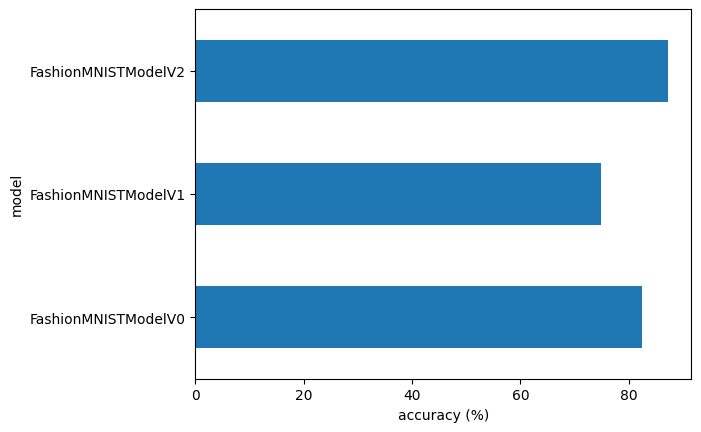

In [ ]:
# Visualize our model results
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model");

In [ ]:
def make_predictions(model:nn.Module, data:list):
    pred_probs = []
    model.eval()

    with torch.inference_mode():

        for sample in data:
            sample = torch.unsqueeze(sample, dim=0)
            pred_logit = model(sample).squeeze()
            pred_prob = torch.softmax(pred_logit, dim=0)
            pred_probs.append(pred_prob)

    return torch.stack(pred_probs)

In [ ]:
import random
torch.manual_seed(42)
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

test_samples[0].shape

torch.Size([1, 28, 28])

In [ ]:
test_labels[0]

9

In [ ]:
class_names[test_labels[1]]

'Coat'

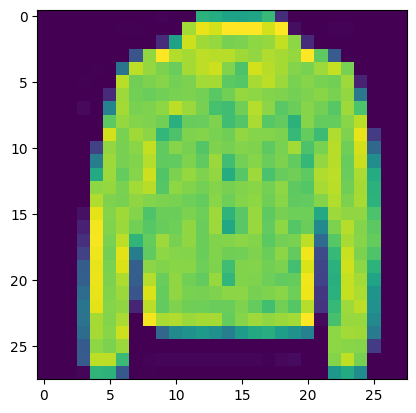

In [ ]:
plt.imshow(test_samples[1][0])

In [ ]:
pred_probs = make_predictions(model=model_2,
                              data=test_samples)
pred_probs

tensor([[6.1737e-09, 2.2790e-09, 1.7378e-08, 1.7478e-09, 3.2699e-05, 1.1774e-03,
         2.7375e-07, 3.0468e-04, 1.7559e-05, 9.9847e-01],
        [5.1107e-04, 1.9263e-05, 1.4138e-01, 1.4288e-05, 8.4423e-01, 1.6051e-06,
         9.2683e-03, 8.6605e-05, 4.1625e-03, 3.3159e-04],
        [9.2793e-01, 5.7852e-04, 7.2504e-04, 3.5571e-03, 2.7580e-04, 4.5372e-06,
         6.6869e-02, 7.7929e-06, 4.6019e-05, 1.1756e-06],
        [1.7365e-02, 1.9435e-02, 3.7255e-04, 9.4061e-02, 8.1386e-01, 6.4186e-06,
         4.4860e-02, 8.2318e-04, 9.2128e-03, 3.8950e-06],
        [1.2183e-08, 3.3087e-10, 8.9990e-08, 1.0879e-09, 6.7177e-06, 1.1593e-03,
         1.1201e-06, 1.2270e-05, 5.7797e-07, 9.9882e-01],
        [2.9684e-05, 4.3576e-07, 4.2082e-05, 7.6211e-06, 8.7665e-06, 9.9819e-01,
         1.3328e-05, 6.1181e-05, 1.6462e-03, 2.6658e-06],
        [1.2994e-07, 2.1867e-08, 2.5847e-07, 6.7556e-07, 7.8176e-05, 8.0303e-03,
         2.1894e-06, 3.2093e-02, 3.5980e-04, 9.5944e-01],
        [1.7242e-06, 6.8185

In [ ]:
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([9, 4, 0, 4, 9, 5, 9, 5, 5])

In [ ]:
torch.tensor(test_labels) == pred_classes

tensor([ True,  True, False,  True,  True,  True,  True,  True,  True])

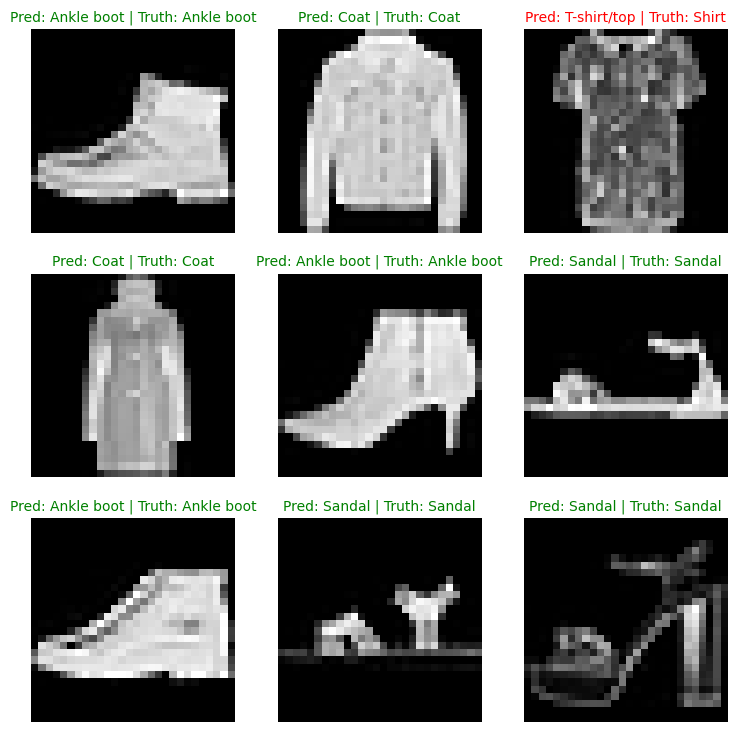

In [ ]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]] 

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  
  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False)

In [ ]:
pred_probs = []
model_2.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc='Make predictions'):
        y_logit = model_2(X)
        y_pred = torch.argmax(y_logit, dim=1)
        pred_probs.append(y_pred)

pred_probs


Make predictions:   0%|          | 0/313 [00:00<?, ?it/s]

[tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 5, 3, 4, 1, 2, 4, 8, 0, 2, 7, 7, 5,
         1, 4, 6, 0, 9, 3, 8, 8]),
 tensor([3, 3, 8, 0, 7, 5, 7, 9, 0, 1, 3, 7, 6, 7, 2, 1, 2, 6, 4, 4, 5, 8, 2, 2,
         8, 4, 8, 0, 7, 7, 8, 5]),
 tensor([1, 1, 2, 3, 7, 8, 7, 0, 2, 2, 2, 3, 1, 2, 8, 4, 1, 8, 5, 9, 5, 0, 3, 2,
         0, 2, 5, 3, 6, 7, 1, 8]),
 tensor([0, 1, 2, 2, 3, 6, 7, 2, 7, 8, 5, 7, 9, 4, 2, 5, 7, 0, 5, 2, 8, 4, 7, 8,
         0, 0, 7, 9, 3, 0, 8, 4]),
 tensor([1, 5, 4, 1, 9, 1, 8, 6, 2, 1, 2, 5, 1, 0, 0, 0, 1, 6, 1, 3, 2, 2, 6, 4,
         1, 3, 5, 6, 4, 7, 9, 3]),
 tensor([7, 2, 3, 9, 0, 9, 2, 7, 4, 2, 0, 5, 2, 1, 2, 1, 3, 0, 9, 1, 0, 9, 3, 0,
         7, 9, 9, 4, 4, 7, 1, 2]),
 tensor([1, 6, 3, 2, 8, 3, 6, 1, 1, 0, 2, 9, 2, 4, 0, 7, 9, 8, 4, 1, 8, 4, 1, 3,
         1, 2, 7, 2, 8, 8, 2, 0]),
 tensor([7, 7, 6, 6, 7, 0, 7, 8, 9, 2, 9, 0, 5, 1, 4, 4, 5, 6, 9, 2, 2, 8, 6, 4,
         2, 2, 9, 7, 6, 5, 5, 2]),
 tensor([8, 5, 2, 3, 0, 4, 8, 0, 0, 6, 3, 8, 9, 6, 1, 3, 0, 2, 3, 0, 8, 

In [ ]:
y_pred_tensor = torch.cat(pred_probs)
y_pred_tensor

tensor([9, 2, 1,  ..., 8, 1, 5])

In [ ]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    pass

mlxtend version: 0.23.0


In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=len(class_names),
                          task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor, target=test_data.targets)
confmat_tensor

tensor([[833,   1,  16,  39,   6,   1,  82,   0,  22,   0],
        [  0, 971,   0,  21,   4,   0,   1,   0,   3,   0],
        [ 13,   0, 841,   9,  71,   0,  63,   0,   3,   0],
        [ 23,   5,  13, 913,  17,   0,  26,   1,   2,   0],
        [  1,   0,  97,  54, 762,   0,  82,   0,   4,   0],
        [  0,   0,   0,   0,   0, 936,   1,  40,   4,  19],
        [189,   2,  94,  38,  73,   0, 575,   0,  29,   0],
        [  0,   0,   0,   0,   0,   6,   0, 980,   1,  13],
        [  1,   2,   5,   7,   1,   2,   6,   4, 972,   0],
        [  0,   0,   0,   0,   0,   3,   0,  57,   1, 939]])

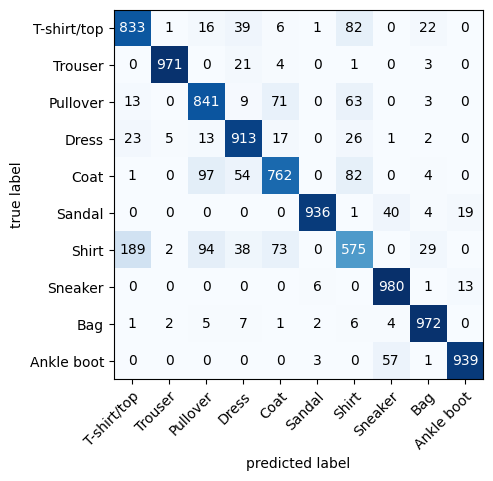

In [ ]:
fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(),
                                class_names=class_names)

In [ ]:
from pathlib import Path

# Create models directory (if it doesn't already exist), see: https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "03_pytorch_computer_vision_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models\03_pytorch_computer_vision_model_2.pth


In [ ]:
loaded_model_2 = FashionMNISTModelV2(input_shape=1,
                                     output_shape=10,
                                     hidden_units=10)
loaded_model_2.load_state_dict(torch.load(MODEL_SAVE_PATH))

<All keys matched successfully>

In [ ]:
loaded_model_2_results = eval_model(model=loaded_model_2,
                                    data_loader=test_dataloader,
                                    loss_fn=loss_fn,
                                    accuracy_fn=accuracy_fn)
loaded_model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3579557538032532,
 'model_acc': 87.22044728434504}

In [ ]:
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3579557538032532,
 'model_acc': 87.22044728434504}

In [ ]:
# Check to see if results are close to each other (if they are very far away, there may be an error)
torch.isclose(torch.tensor(model_2_results["model_loss"]), 
              torch.tensor(loaded_model_2_results["model_loss"]),
              atol=1e-08, # absolute tolerance
              rtol=0.0001) # relative tolerance

tensor(True)